In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import math
import seaborn as sns
from torchsummary import summary
from sklearn.metrics import classification_report, confusion_matrix


# Downloading the MNIST digit datasets

In [2]:
transform = transforms.Compose([transforms.ToTensor()])   # combines a list of transformations
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:03<00:00, 3193275.64it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 499493.62it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4050458.99it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 10021319.71it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000]) # split train_dataset into two
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [4]:
len(train_dataset), len(val_dataset), len(test_dataset)

(50000, 10000, 10000)

# Visualizing the data

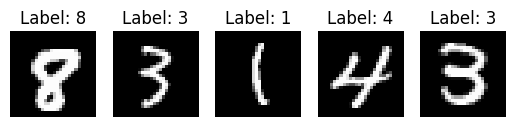

In [5]:
# Get a batch of data
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Display the first 5 images
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f'Label: {labels[i].item()}')
    plt.axis('off')

plt.show()


# CNN Architecture

In [6]:
class CNN(nn.Module):
  def __init__(self, use_batch_norm=False):
    super(CNN, self).__init__()

    # convolutional layers
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1) # 28x28
    self.conv1_bn = nn.BatchNorm2d(32) if use_batch_norm else None
    self.relu1 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 14x14

    self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1) # 14x14
    self.conv2_bn = nn.BatchNorm2d(32) if use_batch_norm else None
    self.relu2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 7x7

    # Fully connected layers
    self.fc1 = nn.Linear(32 * 7 * 7, 500)
    self.fc1_bn = nn.BatchNorm1d(500) if use_batch_norm else None
    self.relu_fc1 = nn.ReLU()
    self.fc2 = nn.Linear(500, 10)

    # Softmax for output layer
    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    # First Conv Block
    x = self.conv1(x)
    x = self.relu1(x)
    x = self.pool1(x)

    # Second Conv Block
    x = self.conv2(x)
    x = self.relu2(x)
    x = self.pool2(x)

    # Flatten the output for fully connected layers
    x = x.view(x.size(0), -1)

    # Fully connected layers
    x = self.fc1(x)
    x = self.relu_fc1(x)
    x = self.fc2(x)
    return x


In [7]:
# Optimizer selection

def optimizer_list(optimizer_type, parameters, lr=0.001, momentum=0.9, weight_decay=0):
    if optimizer_type == "SGD":
        return optim.SGD(parameters, lr=lr, momentum=momentum)
    elif optimizer_type == "Adam":
        return optim.Adam(parameters, lr=lr, weight_decay=weight_decay)
    else:
        raise ValueError(f"Optimizer type {optimizer_type} not recognized.")


# Training the model

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss().to(device)


In [9]:
# Training plotting save the best model
def training_model(optimizer_type, use_batch_norm=False, update_best_model=True):
    net = CNN(use_batch_norm=use_batch_norm).to(device) # initialize the model
    optimizer = optimizer_list(optimizer_type, net.parameters()) # initilaize the optimizer

    num_epochs = 10
    train_losses, val_losses, accuracies = [], [], []

    start_time = time.time() # training time calculator

    # training loop
    for epoch in range(num_epochs):
        train_loss = 0.0
        for inputs, labels in train_loader:   # training batches
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()             # reset the gradients
            outputs = net(inputs)             # Forward pass through the network
            loss = criterion(outputs, labels) # Compute loss
            loss.backward()                   # Backpropagate to compute gradients
            optimizer.step()                  # Update weights using the optimizer
            train_loss += loss.item()         # Accumulate batch loss

        # validation phase
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                val_loss += criterion(outputs, labels).item()  # Compute validation loss
                _, predicted = outputs.max(1)                  # Get predictions
                total += labels.size(0)                        # Total number of samples in validation set
                correct += predicted.eq(labels).sum().item()   # Count correct predictions

        # Calculate average train and validation losses for the epoch
        epoch_train_loss = train_loss / len(train_loader)
        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_accuracy = 100. * correct / total   # Calculate validation accuracy as a percentage

        print(f'Epoch: {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.2f}%')

        # Store the training and validation losses and accuracy for plotting
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        accuracies.append(epoch_val_accuracy)

    # end time and compute the total training duration
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Training using {optimizer_type} with BatchNorm={use_batch_norm} took {elapsed_time:.2f} seconds.")

    # Training and validation losses, and validation accuracy plot
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.legend()
    plt.title(f'{optimizer_type} - Train and Validation Losses')

    plt.subplot(1, 3, 2)
    plt.plot(accuracies, label='Validation Accuracy')
    plt.legend()
    plt.title(f'{optimizer_type} - Validation Accuracy')

    plt.tight_layout()
    plt.show()

    # Testing the model
    test_preds, test_true = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = outputs.max(1) # Get predictions
            test_true.extend(labels.cpu().numpy())   # Store true labels
            test_preds.extend(predicted.cpu().numpy()) # Store predicted labels

     # Test accuracy calculation
    acc = 100. * sum(np.array(test_true) == np.array(test_preds)) / len(test_true)

    # Track the best model and optimizer based on accuracy
    global best_accuracy, best_optimizer, best_model
    if update_best_model and acc > best_accuracy:
        best_accuracy = acc
        best_optimizer = optimizer_type
        best_model = net

    return acc, classification_report(test_true, test_preds, zero_division=0), confusion_matrix(test_true, test_preds), net



# Plot randomly selected test images

In [10]:
# Plot randomly selected images, their true labels and predicted labels from the data loader
def plot_predictions(model, loader, num_samples=9):
    random_images, random_labels = [], []

    for images, labels in loader:     # Loop over the data loader
        random_images.append(images)  # Append the images batch to the list
        random_labels.append(labels)

    # Concatenate all collected batches of images and labels into a single tensor
    random_images = torch.cat(random_images)
    random_labels = torch.cat(random_labels)
    random_indices = random.sample(range(len(random_images)), num_samples) # randomly select images and labels
    images = random_images[random_indices]
    labels = random_labels[random_indices]

    outputs = model(images.to(device)) # model prediction
    _, predictions = outputs.max(1)

    grid_size = int(math.ceil(math.sqrt(num_samples))) # grid size for plotting

    plt.figure(figsize=(6, 6))

    # Loop over selected images, their true labels, and model predictions
    for i, (img, label, pred) in enumerate(zip(images, labels, predictions)):
        plt.subplot(grid_size, grid_size, i+1)
        plt.imshow(img[0].numpy(), cmap='gray')
        plt.title(f"True: {label.item()}, Pred: {pred.item()}", fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Count number of parameters and neurons

In [11]:
def count_parameters_and_neurons(model):
    total_params = 0
    fc_params = 0
    conv_params = 0

    total_neurons = 0
    fc_neurons = 0
    conv_neurons = 0

    height, width = 28, 28

    # child layers of a neural network mode
    for layer in model.children(): # Iterate over each layer in the model
        if isinstance(layer, nn.Conv2d): #  # Check if the layer is a convolutional layer
            conv_params += sum(p.numel() for p in layer.parameters()) # Add the no: of parameters in this Conv layer

            # o/p dimensions after convolution
            height = (height + 2*layer.padding[0] - layer.kernel_size[0]) // layer.stride[0] + 1
            width = (width + 2*layer.padding[1] - layer.kernel_size[1]) // layer.stride[1] + 1

            conv_neurons += layer.out_channels * height * width # o/p size after convolution

        # For MaxPool2d layer
        elif isinstance(layer, nn.MaxPool2d): # Update the o/p dimensions after MaxPooling
            height = (height - layer.kernel_size) // layer.stride + 1
            width = (width - layer.kernel_size) // layer.stride + 1

        # For Linear (fully connected) layer
        elif isinstance(layer, nn.Linear):
            fc_params += sum(p.numel() for p in layer.parameters())
            fc_neurons += layer.out_features

    # calculate total parameters and neurons
    total_params = conv_params + fc_params
    total_neurons = conv_neurons + fc_neurons

    print(f"Total parameters: {total_params}")
    print(f"Parameters in FC layers: {fc_params}")
    print(f"Parameters in Conv layers: {conv_params}")

    print(f"Total neurons: {total_neurons}")
    print(f"Neurons in FC layers: {fc_neurons}")
    print(f"Neurons in Conv layers: {conv_neurons}")

    return {
        "total_parameters": total_params,
        "fc_parameters": fc_params,
        "conv_parameters": conv_params,
        "total_neurons": total_neurons,
        "fc_neurons": fc_neurons,
        "conv_neurons": conv_neurons
    }

In [12]:
# List of optimizer types
optimizer_types = ["SGD", "Adam"]
results = {}  # store results of different optimizers
best_accuracy = 0
best_optimizer = None
best_model = None


Epoch: 1/10, Train Loss: 1.0738, Val Loss: 0.3685, Val Accuracy: 88.92%
Epoch: 2/10, Train Loss: 0.3068, Val Loss: 0.2597, Val Accuracy: 92.18%
Epoch: 3/10, Train Loss: 0.2196, Val Loss: 0.1901, Val Accuracy: 94.16%
Epoch: 4/10, Train Loss: 0.1691, Val Loss: 0.1662, Val Accuracy: 94.82%
Epoch: 5/10, Train Loss: 0.1369, Val Loss: 0.1265, Val Accuracy: 96.06%
Epoch: 6/10, Train Loss: 0.1155, Val Loss: 0.1096, Val Accuracy: 96.62%
Epoch: 7/10, Train Loss: 0.0994, Val Loss: 0.0942, Val Accuracy: 97.12%
Epoch: 8/10, Train Loss: 0.0873, Val Loss: 0.0848, Val Accuracy: 97.52%
Epoch: 9/10, Train Loss: 0.0784, Val Loss: 0.0810, Val Accuracy: 97.56%
Epoch: 10/10, Train Loss: 0.0736, Val Loss: 0.0740, Val Accuracy: 97.63%
Training using SGD with BatchNorm=False took 98.45 seconds.


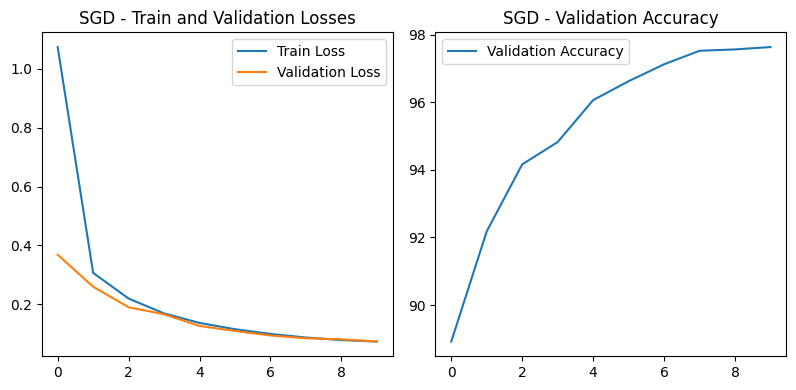

Epoch: 1/10, Train Loss: 0.1742, Val Loss: 0.0609, Val Accuracy: 98.01%
Epoch: 2/10, Train Loss: 0.0471, Val Loss: 0.0504, Val Accuracy: 98.51%
Epoch: 3/10, Train Loss: 0.0320, Val Loss: 0.0393, Val Accuracy: 98.91%
Epoch: 4/10, Train Loss: 0.0246, Val Loss: 0.0335, Val Accuracy: 99.02%
Epoch: 5/10, Train Loss: 0.0184, Val Loss: 0.0326, Val Accuracy: 99.13%
Epoch: 6/10, Train Loss: 0.0141, Val Loss: 0.0446, Val Accuracy: 99.00%
Epoch: 7/10, Train Loss: 0.0116, Val Loss: 0.0462, Val Accuracy: 98.91%
Epoch: 8/10, Train Loss: 0.0106, Val Loss: 0.0487, Val Accuracy: 98.79%
Epoch: 9/10, Train Loss: 0.0080, Val Loss: 0.0436, Val Accuracy: 98.93%
Epoch: 10/10, Train Loss: 0.0073, Val Loss: 0.0541, Val Accuracy: 98.85%
Training using Adam with BatchNorm=False took 86.69 seconds.


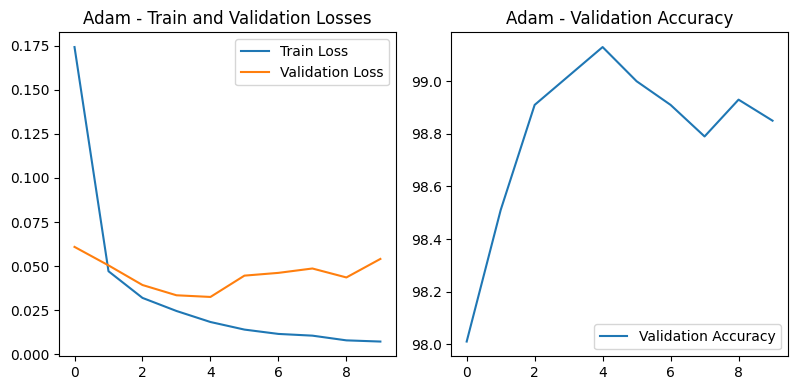

In [13]:
# Loop through each optimizer type
for opt in optimizer_types:
    accuracy, class_report, conf_matrix, _ = training_model(opt) # train the model
    results[opt] = {                              # store the results in dictionary
        "Accuracy": accuracy,
        "Classification Report": class_report,
        "Confusion Matrix": conf_matrix
    }

In [14]:
# Display accuracy, test loss,and a heatmap for the confusion matrix.

def results_display(optimizer_type, results):
  print(f"\nResults for {optimizer_type} optimizer:")
  print(f"Accuracy: {results['Accuracy']:.2f}%")
  #print(f"\nClassification Report:\n{results['Classification Report']}")

  plt.figure(figsize=(8, 6))
  sns.heatmap(results["Confusion Matrix"], annot=True, fmt="d", cmap="Greens")
  plt.title(f"Confusion Matrix for {optimizer_type} optimizer")
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.show()



Results for SGD optimizer:
Accuracy: 97.88%


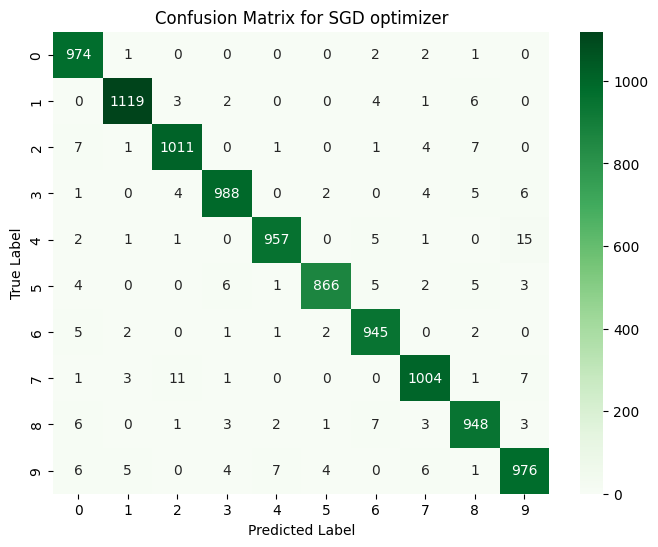

In [15]:
results_display("SGD", results["SGD"])


Results for Adam optimizer:
Accuracy: 99.11%


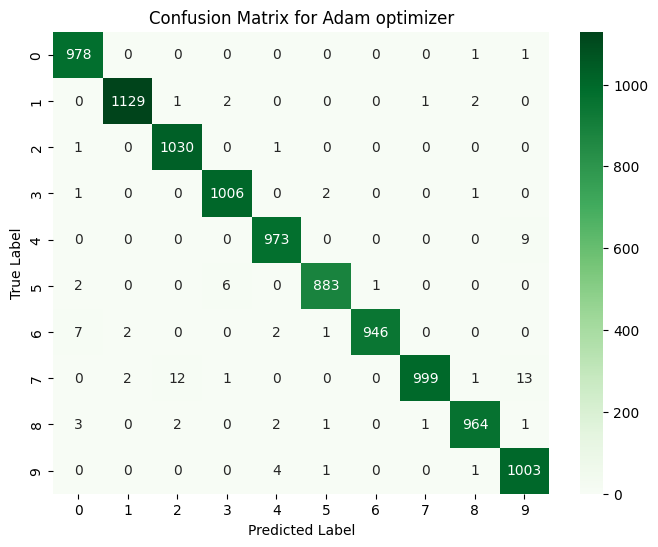

In [16]:
results_display("Adam", results["Adam"])

# Save the best model

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
save_path = "/content/drive/MyDrive/PhD/SEM_2/DL/LAB/LAB2/best_model_{}_optimizer.pth".format(best_optimizer)
torch.save(best_model.state_dict(), save_path)
print(f"Best model saved to Google Drive with {best_optimizer} optimizer, achieved accuracy: {best_accuracy:.2f}%")


Best model saved to Google Drive with Adam optimizer, achieved accuracy: 99.11%


In [19]:
# Best model
top_model = CNN() # include the architecture of network
top_model.load_state_dict(torch.load(save_path)) # load_state_dict loads weights into the top_model
top_model.eval()


<ipython-input-19-2c5601d762cb>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  top_model.load_state_dict(torch.load(save_path)) # load_state_dict loads weights into the to

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=500, bias=True)
  (relu_fc1): ReLU()
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

# Plotting random images

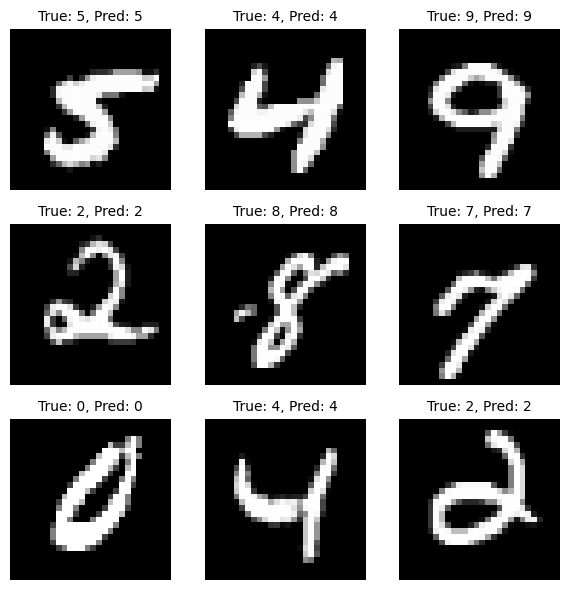

In [20]:
top_model = top_model.to(device)
plot_predictions(top_model, test_loader)

# Dimensions of the input and output at each layer.

In [21]:
summary(top_model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           9,248
              ReLU-5           [-1, 32, 14, 14]               0
         MaxPool2d-6             [-1, 32, 7, 7]               0
            Linear-7                  [-1, 500]         784,500
              ReLU-8                  [-1, 500]               0
            Linear-9                   [-1, 10]           5,010
Total params: 799,078
Trainable params: 799,078
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.55
Params size (MB): 3.05
Estimated Total Size (MB): 3.60
-------------------------------------------

# Number of parameters and neurons

In [22]:
count_parameters_and_neurons(top_model)

Total parameters: 799078
Parameters in FC layers: 789510
Parameters in Conv layers: 9568
Total neurons: 31870
Neurons in FC layers: 510
Neurons in Conv layers: 31360


{'total_parameters': 799078,
 'fc_parameters': 789510,
 'conv_parameters': 9568,
 'total_neurons': 31870,
 'fc_neurons': 510,
 'conv_neurons': 31360}

# Batch Normalization

Epoch: 1/10, Train Loss: 1.5040, Val Loss: 0.4241, Val Accuracy: 87.11%
Epoch: 2/10, Train Loss: 0.3426, Val Loss: 0.2857, Val Accuracy: 91.25%
Epoch: 3/10, Train Loss: 0.2446, Val Loss: 0.2000, Val Accuracy: 93.89%
Epoch: 4/10, Train Loss: 0.1897, Val Loss: 0.1685, Val Accuracy: 95.03%
Epoch: 5/10, Train Loss: 0.1509, Val Loss: 0.1393, Val Accuracy: 95.73%
Epoch: 6/10, Train Loss: 0.1253, Val Loss: 0.1141, Val Accuracy: 96.66%
Epoch: 7/10, Train Loss: 0.1069, Val Loss: 0.0965, Val Accuracy: 97.03%
Epoch: 8/10, Train Loss: 0.0924, Val Loss: 0.0913, Val Accuracy: 97.33%
Epoch: 9/10, Train Loss: 0.0839, Val Loss: 0.0812, Val Accuracy: 97.54%
Epoch: 10/10, Train Loss: 0.0761, Val Loss: 0.0822, Val Accuracy: 97.56%
Training using SGD with BatchNorm=True took 88.57 seconds.


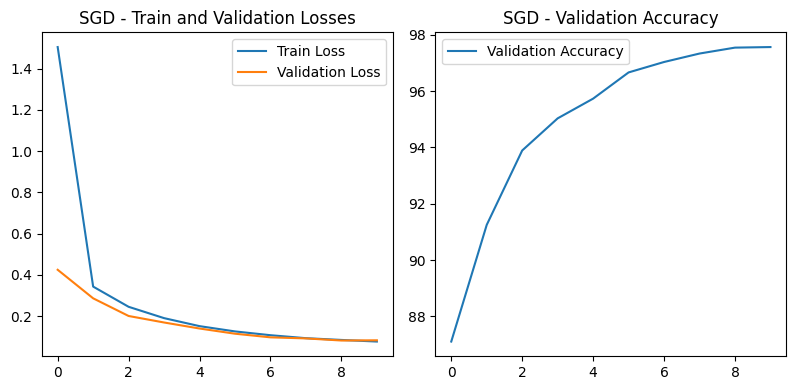

In [23]:
sgd_batch_acc, sgd_batch_classrepo, sgd_batch_confmat, sgd_batch_model = training_model(optimizer_type = "SGD", use_batch_norm=True, update_best_model=False)
sgd_batch_results = {
        "Accuracy": sgd_batch_acc,
        "Classification Report": sgd_batch_classrepo,
        "Confusion Matrix": sgd_batch_confmat
    }



Results for SGD optimizer:
Accuracy: 97.71%


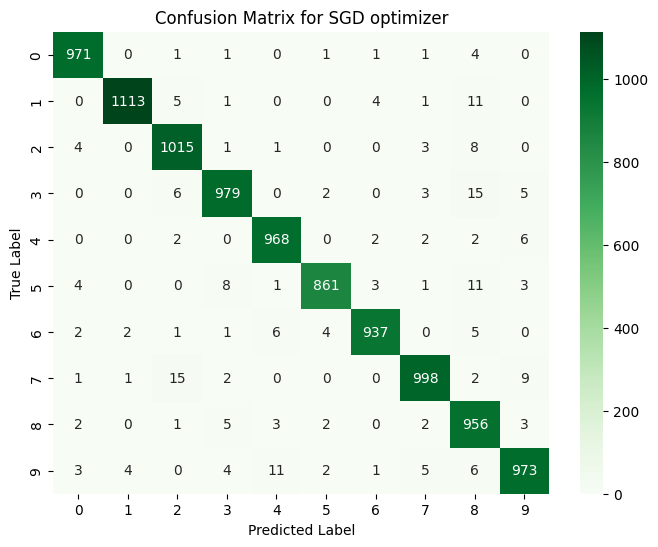

In [24]:
results_display(optimizer_type = "SGD", results = sgd_batch_results)

Epoch: 1/10, Train Loss: 0.1983, Val Loss: 0.0849, Val Accuracy: 97.43%
Epoch: 2/10, Train Loss: 0.0538, Val Loss: 0.0527, Val Accuracy: 98.37%
Epoch: 3/10, Train Loss: 0.0373, Val Loss: 0.0418, Val Accuracy: 98.65%
Epoch: 4/10, Train Loss: 0.0274, Val Loss: 0.0410, Val Accuracy: 98.93%
Epoch: 5/10, Train Loss: 0.0204, Val Loss: 0.0409, Val Accuracy: 98.73%
Epoch: 6/10, Train Loss: 0.0176, Val Loss: 0.0421, Val Accuracy: 98.77%
Epoch: 7/10, Train Loss: 0.0122, Val Loss: 0.0377, Val Accuracy: 99.02%
Epoch: 8/10, Train Loss: 0.0121, Val Loss: 0.0495, Val Accuracy: 98.84%
Epoch: 9/10, Train Loss: 0.0090, Val Loss: 0.0475, Val Accuracy: 98.77%
Epoch: 10/10, Train Loss: 0.0084, Val Loss: 0.0388, Val Accuracy: 99.08%
Training using Adam with BatchNorm=True took 87.72 seconds.


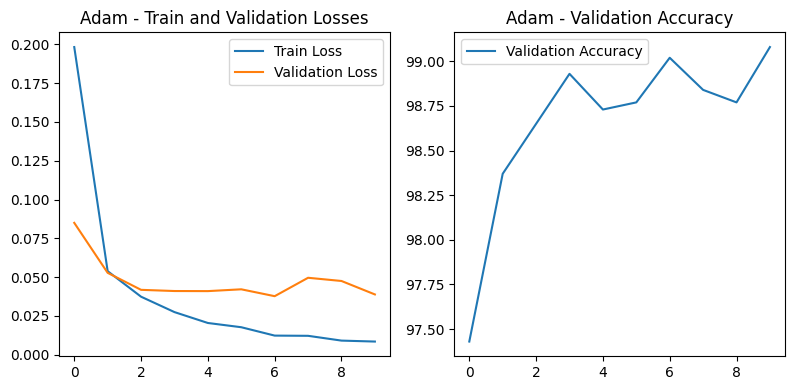

In [25]:
adam_batch_acc, adam_batch_classrepo, adam_batch_confmat, adam_batch_model = training_model(optimizer_type = "Adam", use_batch_norm=True, update_best_model=False)
adam_batch_results = {
        "Accuracy": adam_batch_acc,
        "Classification Report": adam_batch_classrepo,
        "Confusion Matrix": adam_batch_confmat
    }


Results for Adam optimizer:
Accuracy: 98.97%


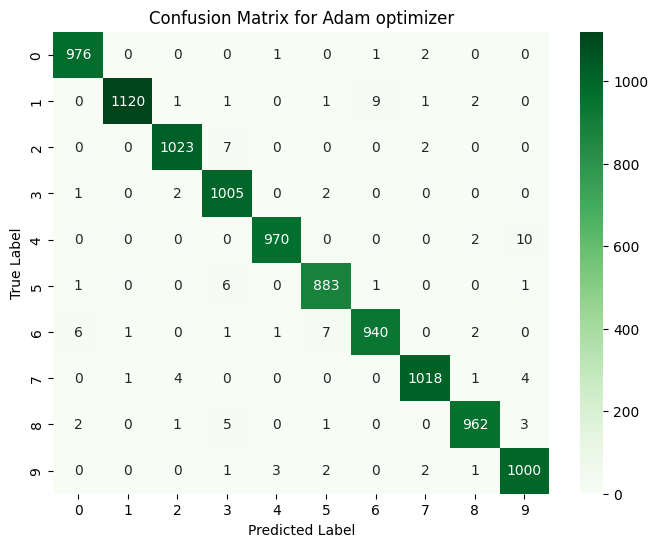

In [26]:
results_display(optimizer_type = "Adam", results = adam_batch_results)

# Visualizing Convolutional Neural Networks

Conv1 Layer Filters:


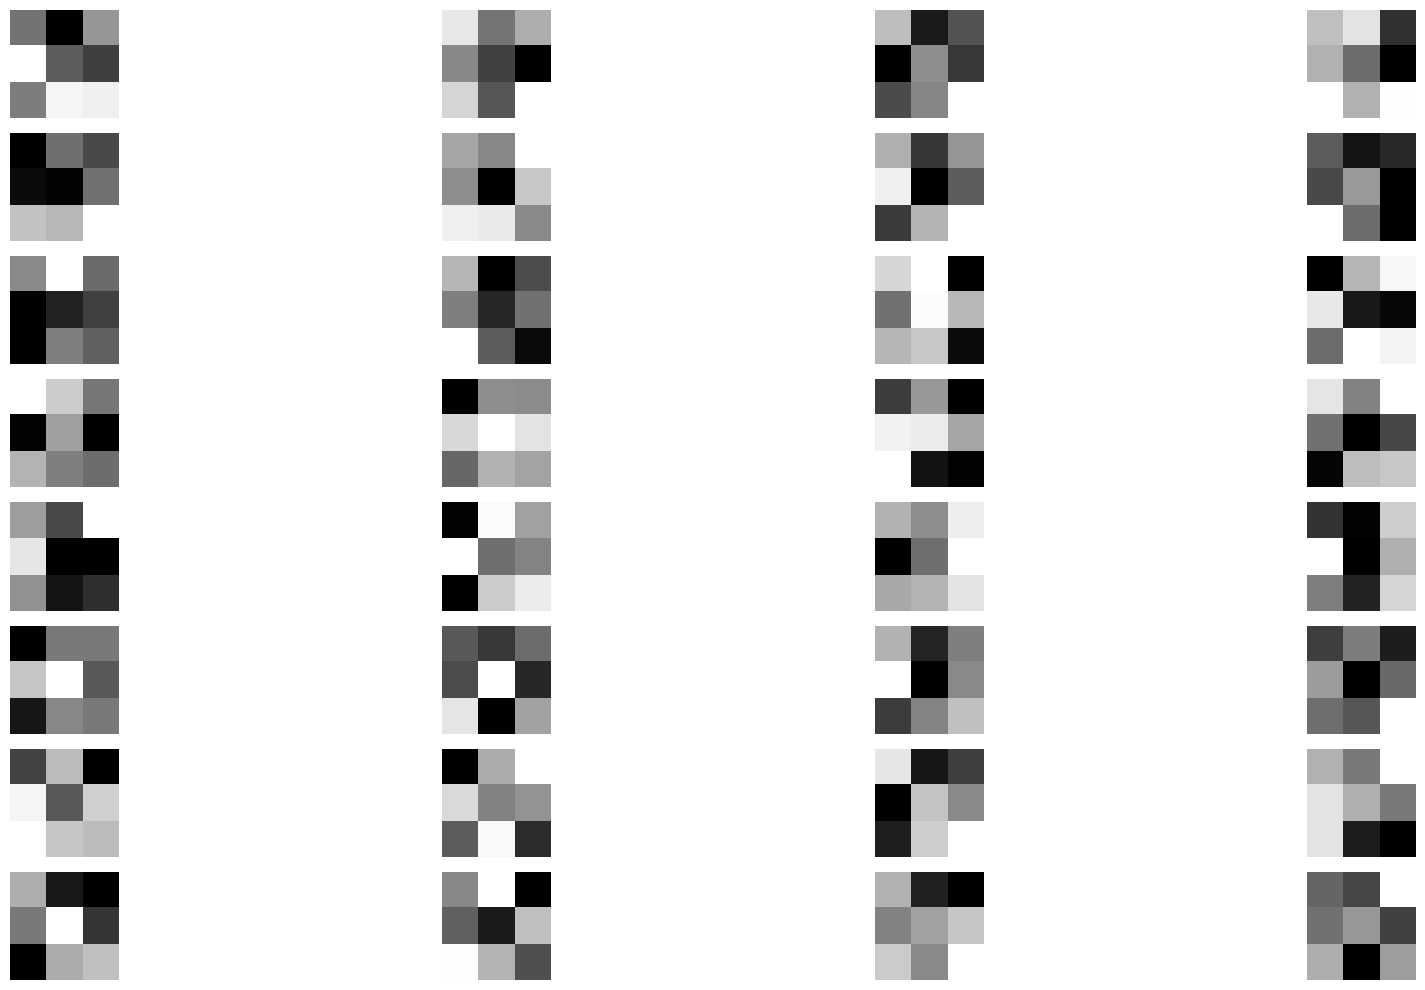

Conv2 Layer Filters:


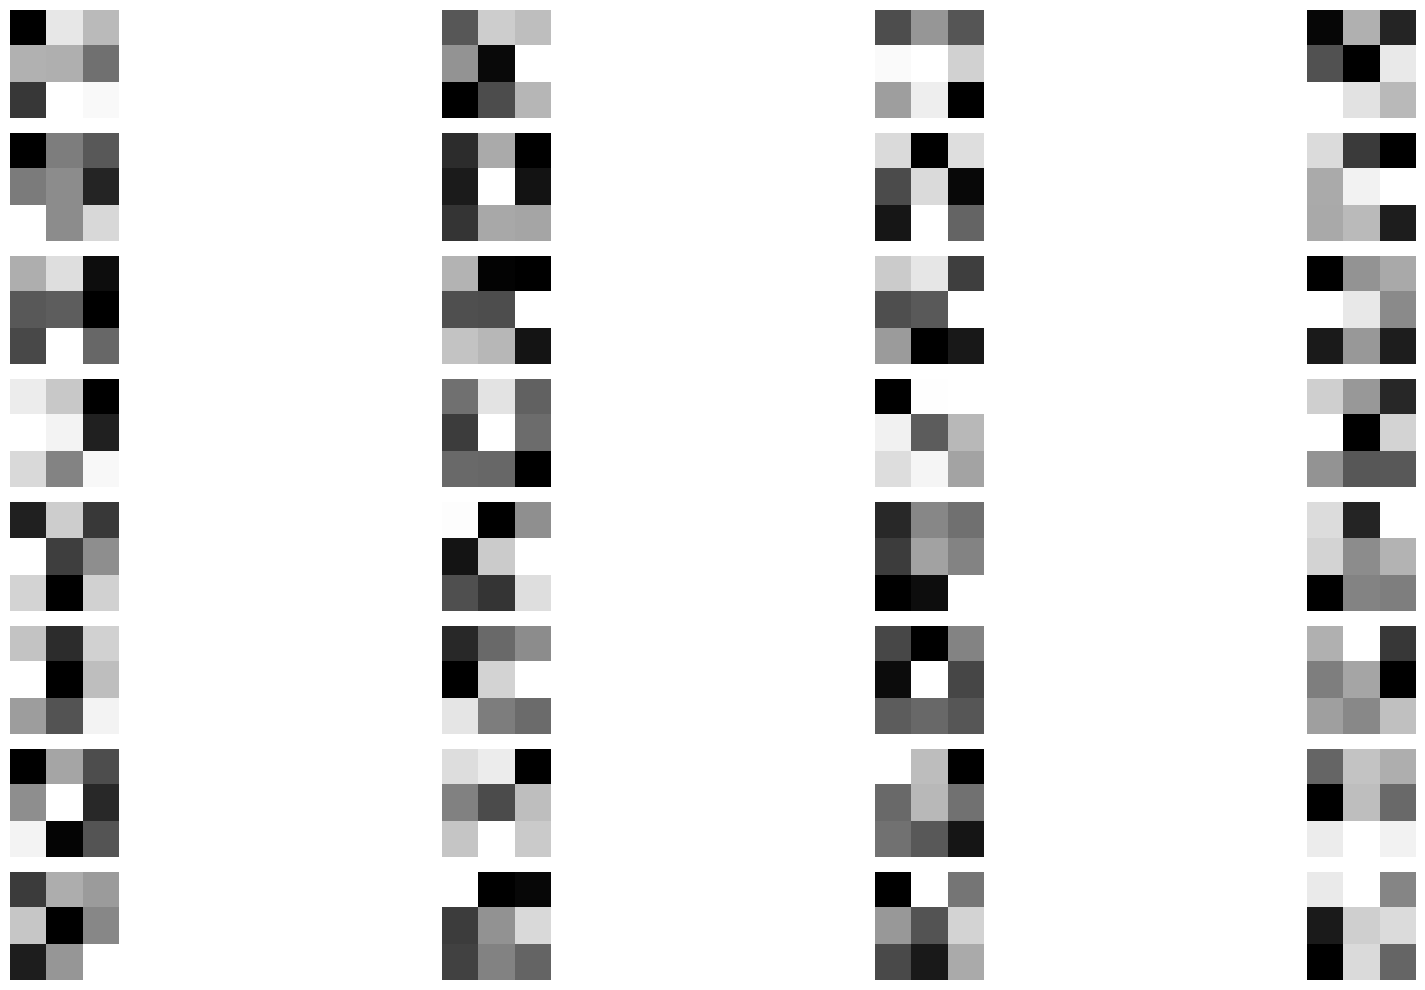

In [27]:
# Function to visualize filters
def plot_filters(layer, num_columns=4):
    filters = layer.weight.data.cpu()  # Get filters (weights)
    num_filters = filters.shape[0]     # No: of filters (kernels)
    num_rows = (num_filters + num_columns - 1) // num_columns  # No: of rows in the plot grid

    fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 10))

    # Loop through filters and plot them
    for i, ax in enumerate(axes.flat):
        if i < num_filters:
            ax.imshow(filters[i, 0], cmap="gray")  # first channel of each filter
        ax.axis('off')

    plt.tight_layout()
    plt.show()

model = CNN()
model.eval()

# Plot filters of conv1 layer
print("Conv1 Layer Filters:")
plot_filters(model.conv1)

# Plot filters of conv2 layer
print("Conv2 Layer Filters:")
plot_filters(model.conv2)


# Visualize the activations of the convolutional layers.

In [28]:
def activations(model, image, layer_name, num_columns=8):
    # Store activations
    activations = []

    # Hook function to store layer output
    def hook(module, input, output):
        activations.append(output)

    # Register the hook for the specified layer (e.g., 'conv1', 'conv2')
    layer = getattr(model, layer_name)  # Access the layer by name
    handle = layer.register_forward_hook(hook)

    # Pass the image through the model to get activations
    model.eval()
    with torch.no_grad():
        model(image.unsqueeze(0))  # Add batch dimension

    # Remove the hook
    handle.remove()

    # Process activations
    act = activations[0].squeeze().cpu().detach().numpy()  # Get the activation data
    num_filters = act.shape[0]
    num_rows = int(np.ceil(num_filters / num_columns))

    # Plot activations
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        if i < num_filters:
            ax.imshow(act[i], cmap="gray")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

    return act


In [29]:
sample_img, _ = next(iter(test_loader))
sample_img = sample_img.to(device)

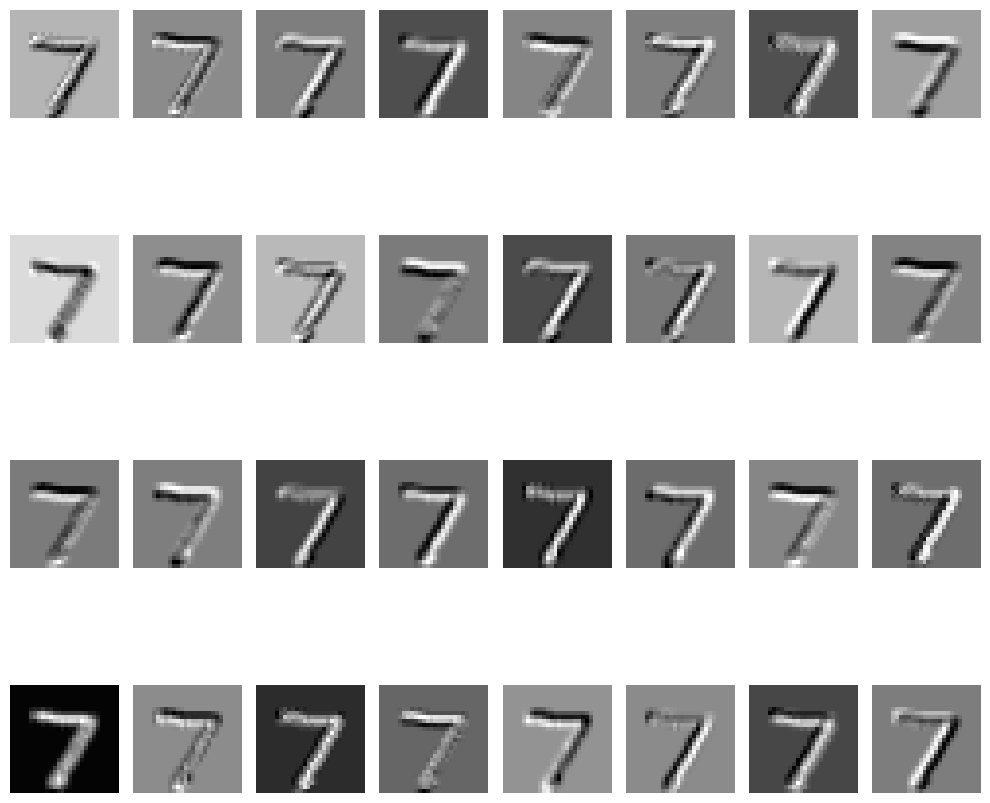

In [30]:
# Visualize activations from the first convolutional layer (conv1)
activation_val_conv1 = activations(model=adam_batch_model, image=sample_img[0], layer_name='conv1')

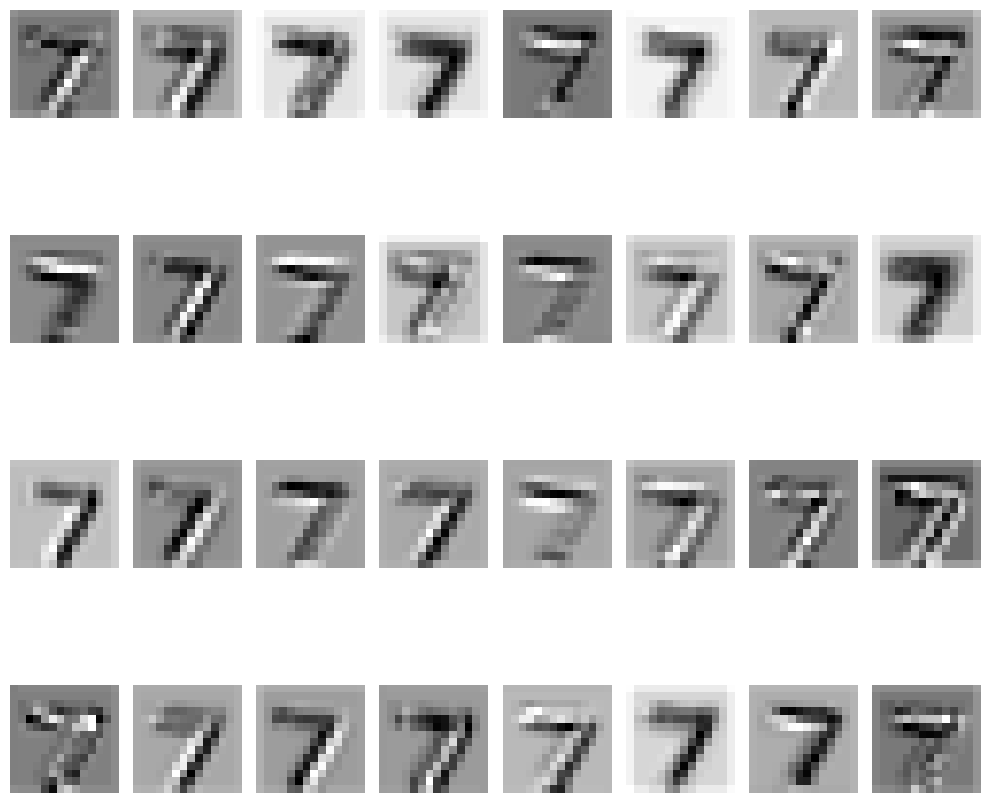

In [31]:
# Visualize activations from the second convolutional layer (conv2)
activation_val_conv2 = activations(model=adam_batch_model, image=sample_img[0], layer_name='conv2')


# Occluding parts of the image

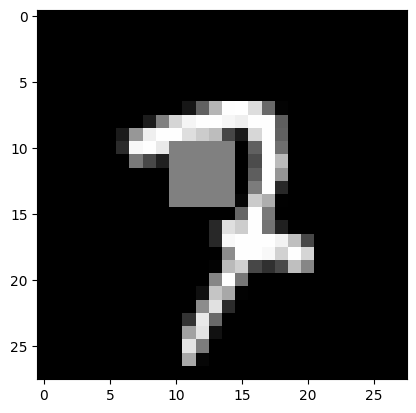

In [32]:
# Sample batch from the test_loader
test_features, test_labels = next(iter(test_loader))
rand_samples = np.random.choice(test_features.shape[0], 10) # select 10 samples from the test set

# Set occluder size and position
size = 5
x = y = 10
# Sample with occlusion
temp = torch.clone(test_features[rand_samples[0]].cpu().reshape(28, 28))
temp[x:x + size, y:y + size] = torch.full((size, size), 0.5)  # Set the occluded area

plt.imshow(temp, cmap='gray')


0.015031811781227589


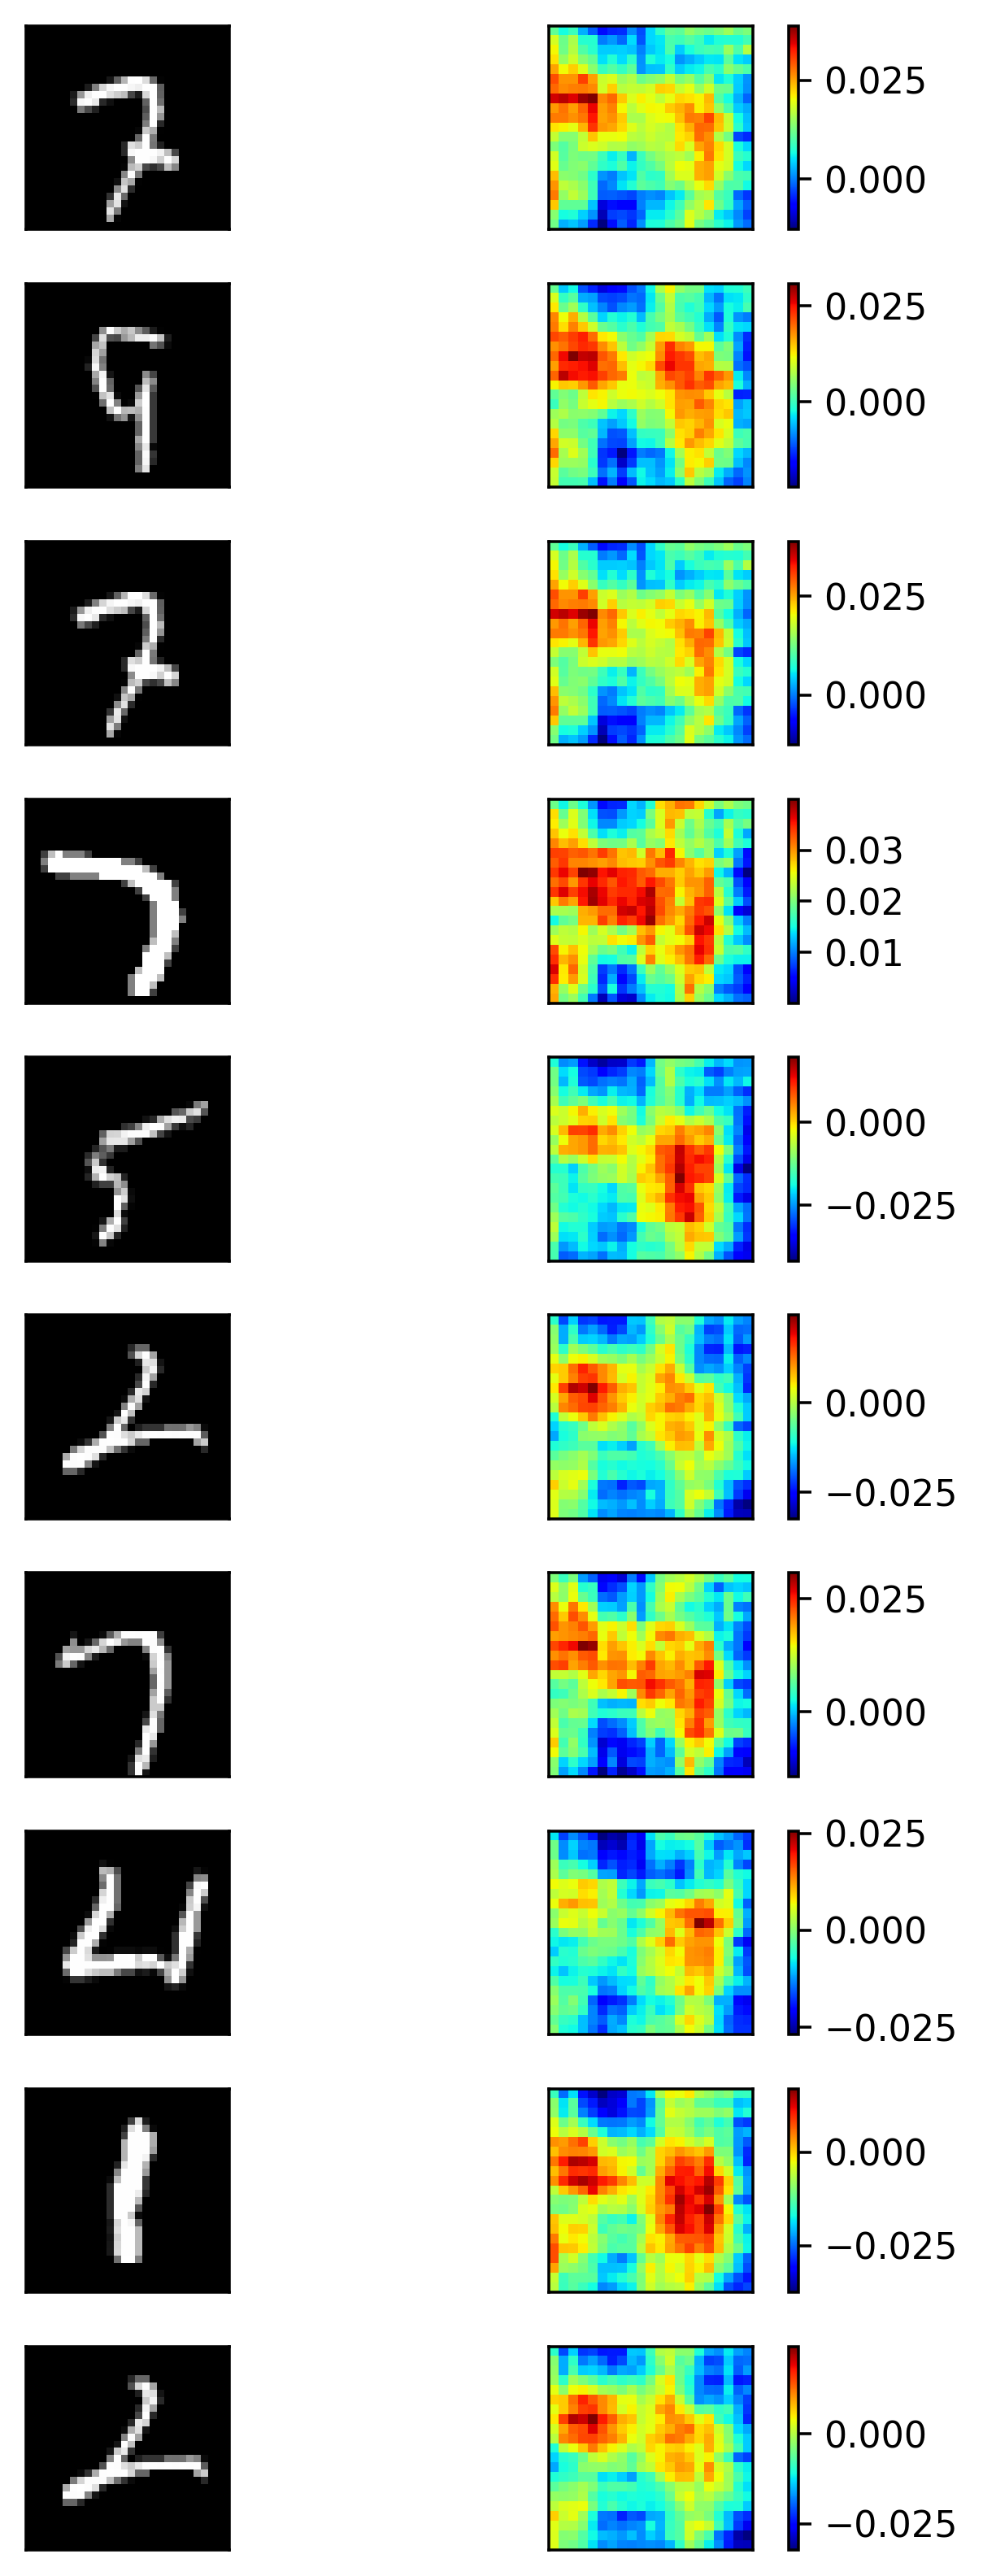

In [33]:
# probability of the target class before occlusion
predicted_prob = model.forward(temp.reshape(1, 1, 28, 28).cpu()).detach()[0][test_labels[rand_samples[0]].argmax().item()].item()
print(predicted_prob)

size = 7 # Probability map initialization
prob = np.zeros((len(range(0, 28 - size)), len(range(0, 28 - size)), 10))

# Iterate over positions for occlusion
for i in range(0, 28 - size):
    for j in range(0, 28 - size):
        for k in range(10):
            # occluded image for the current sample
            temp = torch.clone(test_features[rand_samples[k]].reshape(28, 28))
            temp[i:i + size, j:j + size] = torch.full((size, size), 1)  # Occlude with white square

            # predicted probability for the target class
            prob[i, j, k] = model.forward(temp.reshape(1, 1, 28, 28).cpu()).detach()[0][test_labels[rand_samples[k]].argmax().item()].item()

# original images and probability maps
fig, axs = plt.subplots(10, 2, figsize=(5, 10), dpi=320)
for i in range(10):
    # Original image
    axs[i, 0].xaxis.set_visible(False)
    axs[i, 0].yaxis.set_visible(False)
    axs[i, 0].imshow(test_features[rand_samples[i]].reshape(28, 28), cmap="gray")

    # Probability map
    axs[i, 1].xaxis.set_visible(False)
    axs[i, 1].yaxis.set_visible(False)
    im = axs[i, 1].imshow(prob[:, :, i], cmap='jet')
    plt.colorbar(im, ax=axs[i, 1])

plt.tight_layout()
plt.show()


-0.029278360307216644


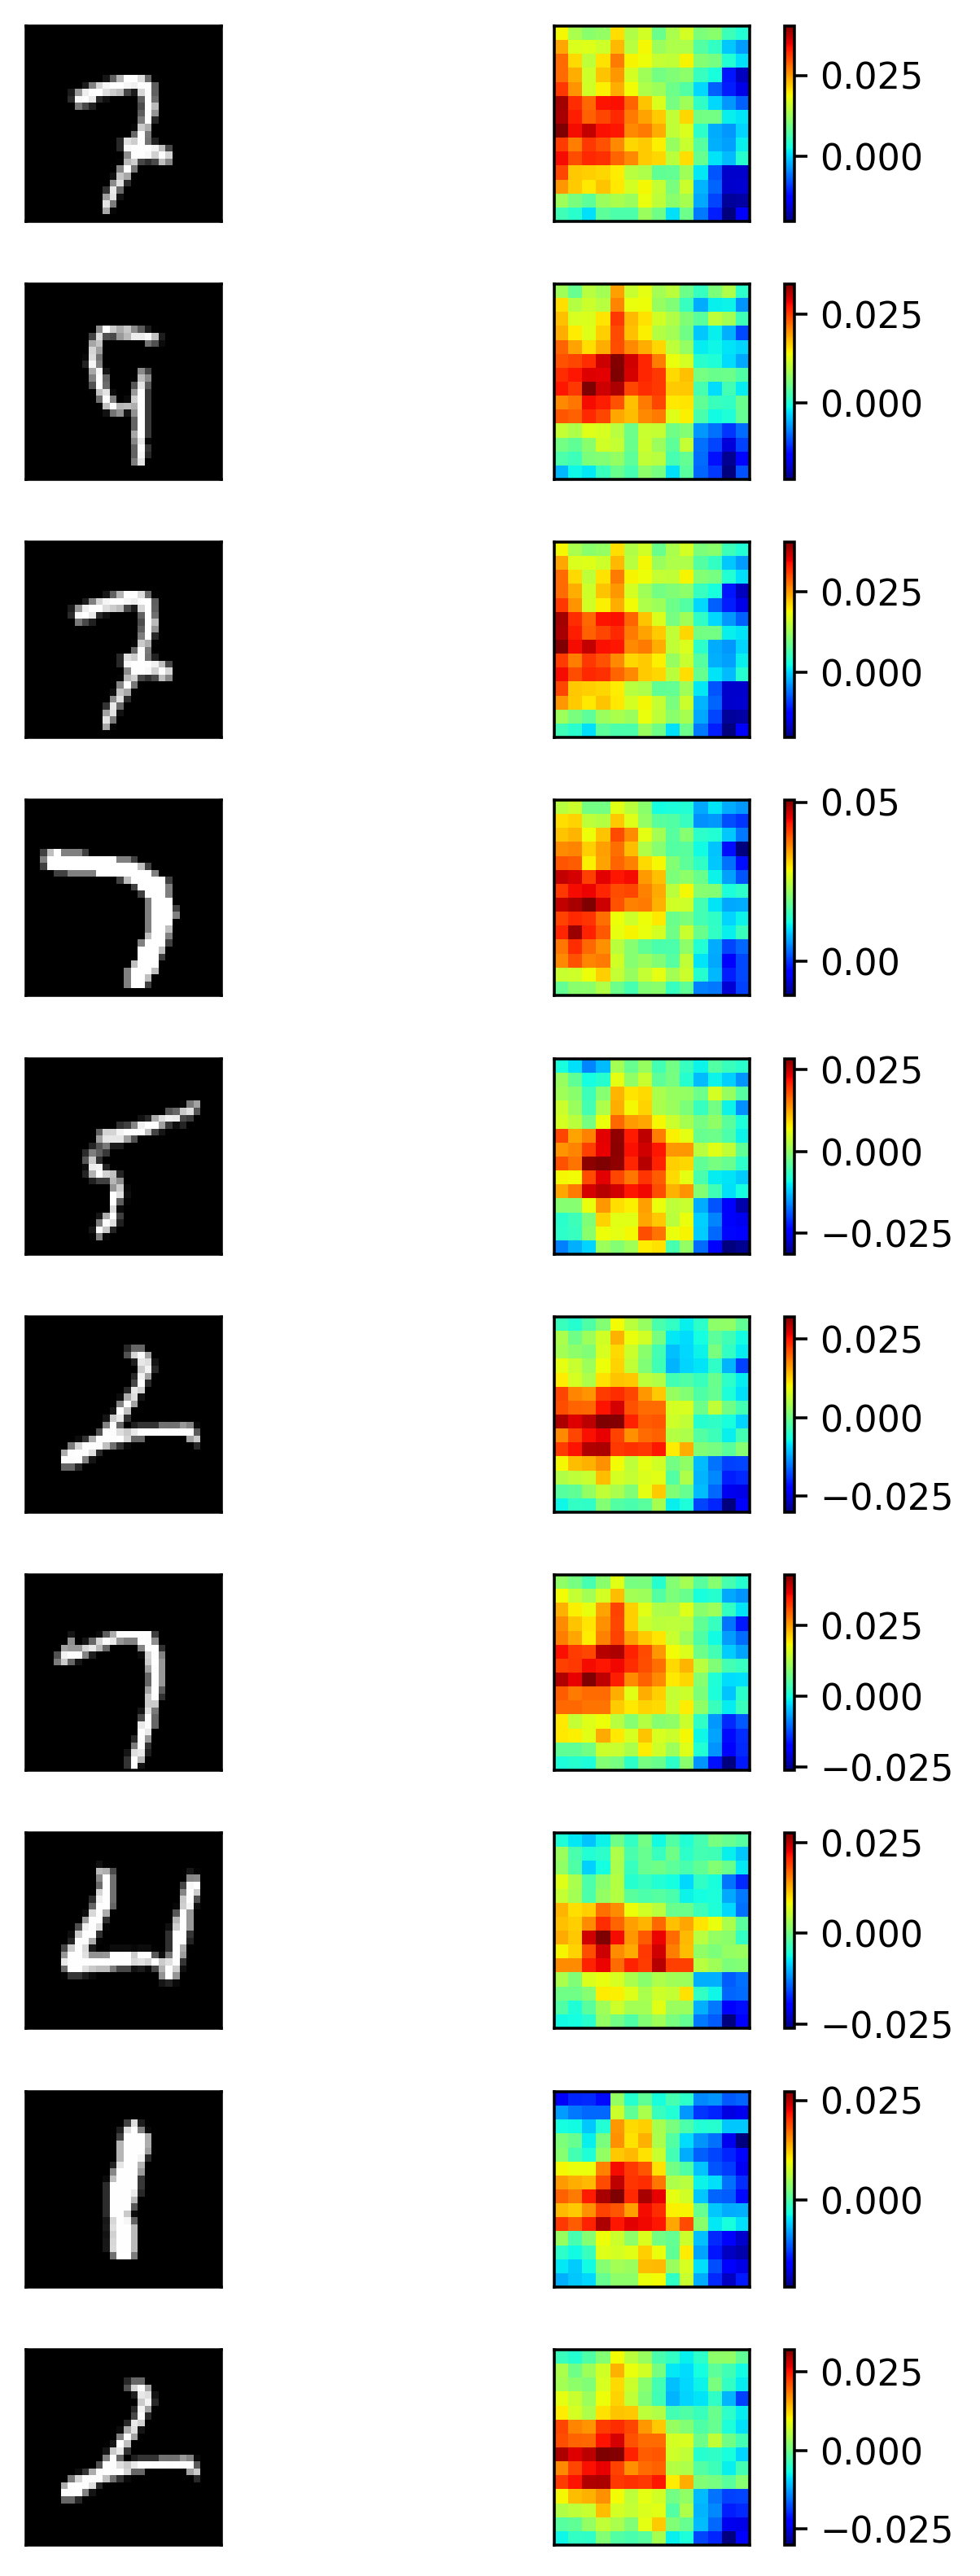

In [34]:
# Probability of the target class before occlusion
predicted_prob = model.forward(temp.reshape(1, 1, 28, 28).cpu()).detach()[0][test_labels[rand_samples[0]].argmax().item()].item()
print(predicted_prob)

size = 14  # Updated size for the occlusion patch

# Probability map initialization
prob = np.zeros((len(range(0, 28 - size)), len(range(0, 28 - size)), 10))

# Iterate over positions for occlusion
for i in range(0, 28 - size):
    for j in range(0, 28 - size):
        for k in range(10):
            # Occluded image for the current sample
            temp = torch.clone(test_features[rand_samples[k]].reshape(28, 28))
            temp[i:i + size, j:j + size] = torch.full((size, size), 1)  # Occlude with white square

            # Predicted probability for the target class
            prob[i, j, k] = model.forward(temp.reshape(1, 1, 28, 28).cpu()).detach()[0][test_labels[rand_samples[k]].argmax().item()].item()

# Original images and probability maps
fig, axs = plt.subplots(10, 2, figsize=(5, 10), dpi=320)
for i in range(10):
    # Original image
    axs[i, 0].xaxis.set_visible(False)
    axs[i, 0].yaxis.set_visible(False)
    axs[i, 0].imshow(test_features[rand_samples[i]].reshape(28, 28), cmap="gray")

    # Probability map
    axs[i, 1].xaxis.set_visible(False)
    axs[i, 1].yaxis.set_visible(False)
    im = axs[i, 1].imshow(prob[:, :, i], cmap='jet')
    plt.colorbar(im, ax=axs[i, 1])

plt.tight_layout()
plt.show()


# Adversarial Examples

# Non-Targeted Attack

In [41]:
# Adversarial example generation

def generate_adversarial_example_with_costs(model, target_class, stepsize=0.05, max_iterations=10000, epsilon=0.3, use_epsilon=True):
  model.eval() # evaluate model

  X = torch.normal(128, 1, (1, 1, 28, 28)).to(device) # normal distribution centered around 128
  X.requires_grad = True
  costs = [] # store the cost

  for iteration in range(max_iterations):
    logits = model(X) # output of the model before applying softmax
    cost = logits[0, target_class] # Output for the target class
    costs.append(cost.item())

    model.zero_grad() # Clear previous gradients
    cost.backward()  # Compute gradients w.r.t. X

    perturbation = stepsize * X.grad.data # Scale the gradient by stepsize
    if use_epsilon:
      perturbation = torch.clamp(perturbation, -epsilon, epsilon)
    X.data = X.data + perturbation # update the image

    X.data = torch.clamp(X.data, 0, 255)
    X.grad.data.zero_() # Clear the gradient for the next iteration

  return X.detach(), costs

In [42]:
def plot_costs_for_target_class(generated_examples, target_class):
  costs = generated_examples['cost'][target_class] # Extract the cost values for the specified target class

  plt.figure(figsize=(8, 6))
  plt.plot(costs)
  plt.xlabel('Iterations')
  plt.ylabel('Cost Value')
  plt.title(f"Cost Function for Target Class {target_class} over Iterations")
  plt.grid(True)
  plt.show()


In [43]:
def display_adversarial_images(generated_examples):
  plt.figure(figsize=(10, 5))

  # Iterate over the generated adversarial examples
  for i, img in generated_examples['gen_egs'].items():
    plt.subplot(2, 5, i+1)
    plt.imshow(img.cpu().squeeze().numpy(), cmap='gray')
    plt.title(f"Target: {i}")
    plt.axis('off')
  plt.tight_layout()
  plt.show()

In [44]:
def check_network_predictions(model, generated_examples):
    for i, img in generated_examples['gen_egs'].items():
        logits = model(img)
        probs = torch.nn.functional.softmax(logits, dim=1)
        pred_class = torch.argmax(probs, dim=1).item()
        confidence = probs[0, pred_class].item()

        print(f"Target Class: {i}, Predicted Class: {pred_class}, Confidence: {confidence:.4f}")


In [45]:
# dictionary to store generated adversarial examples ('gen_egs') and their associated costs ('cost')
generated_examples = {'gen_egs': {}, 'cost': {}}
for i in range(10):
  gen_eg, cost = generate_adversarial_example_with_costs(adam_batch_model, i) # Generate adversarial example and its cost
  generated_examples['gen_egs'][i] = gen_eg # Store the generated adversarial eg for the current target class (i)
  generated_examples['cost'][i] = cost # Store the cost function values for the current target class (i)

In [46]:
check_network_predictions(adam_batch_model, generated_examples)

Target Class: 0, Predicted Class: 0, Confidence: 1.0000
Target Class: 1, Predicted Class: 1, Confidence: 1.0000
Target Class: 2, Predicted Class: 2, Confidence: 1.0000
Target Class: 3, Predicted Class: 3, Confidence: 1.0000
Target Class: 4, Predicted Class: 4, Confidence: 1.0000
Target Class: 5, Predicted Class: 5, Confidence: 1.0000
Target Class: 6, Predicted Class: 6, Confidence: 1.0000
Target Class: 7, Predicted Class: 7, Confidence: 1.0000
Target Class: 8, Predicted Class: 8, Confidence: 1.0000
Target Class: 9, Predicted Class: 9, Confidence: 1.0000


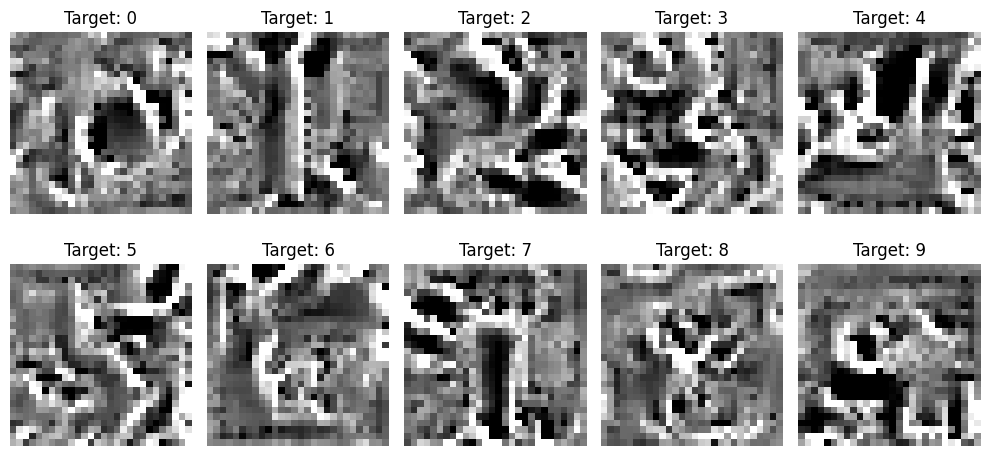

In [47]:
display_adversarial_images(generated_examples)

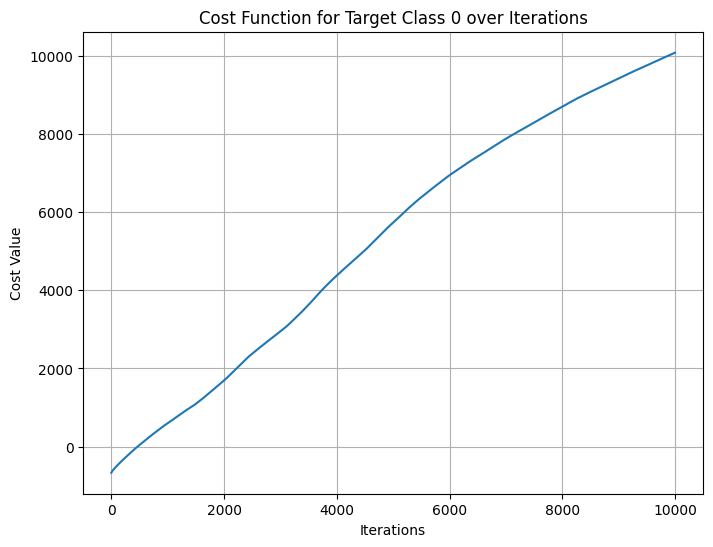

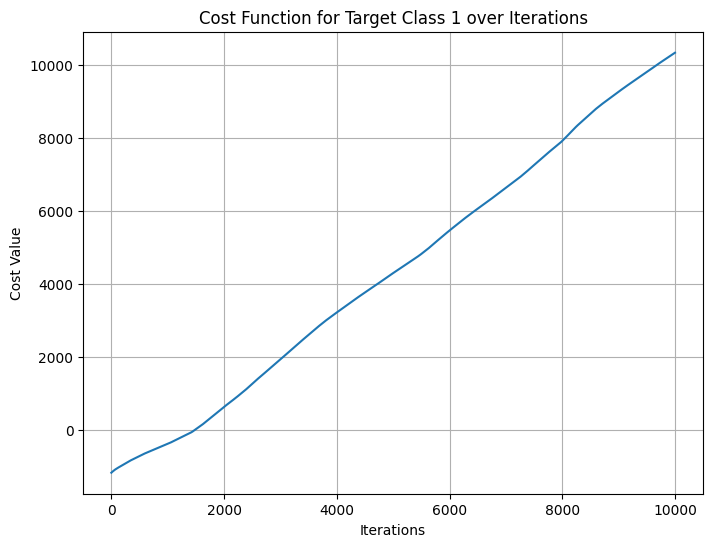

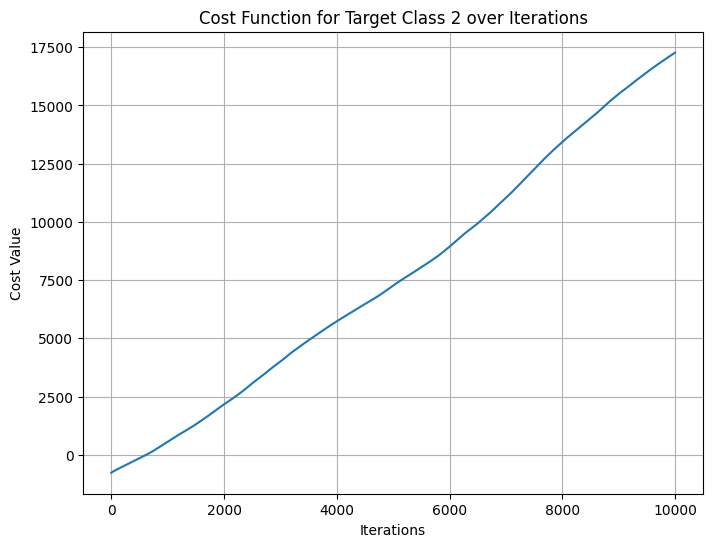

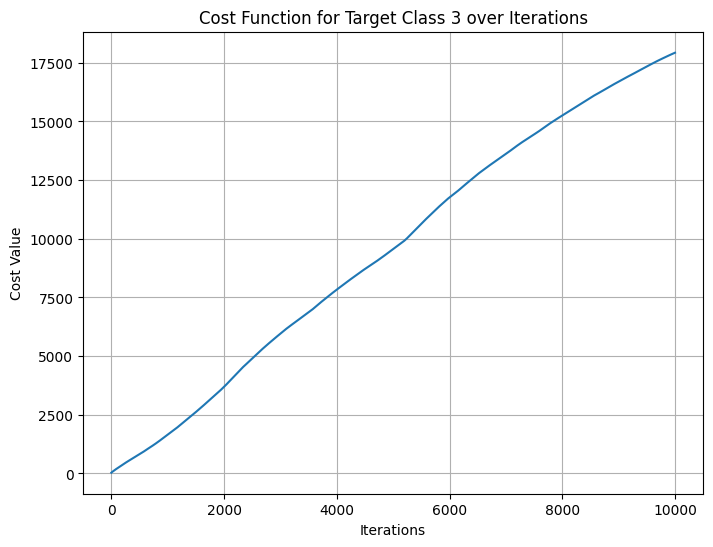

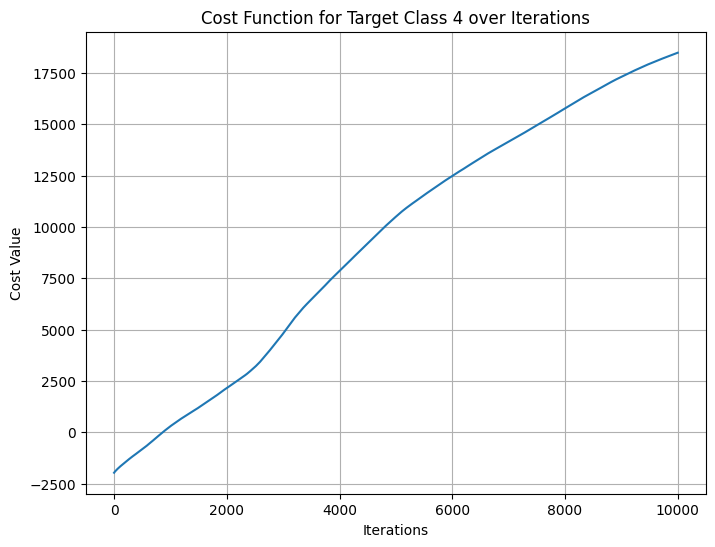

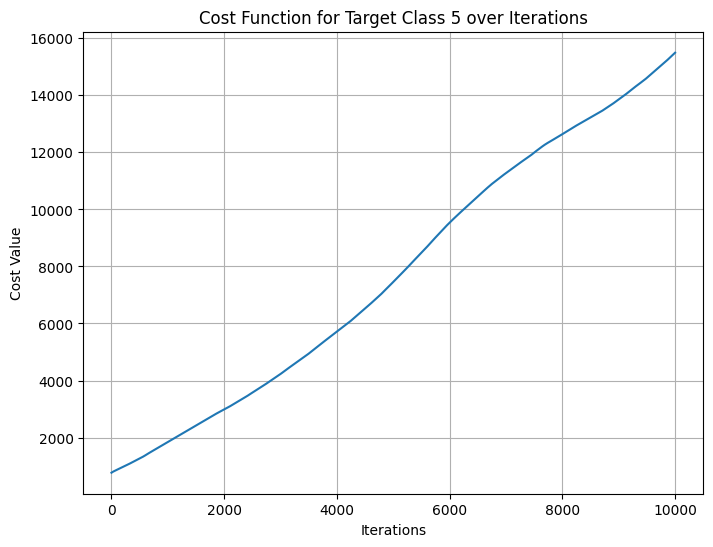

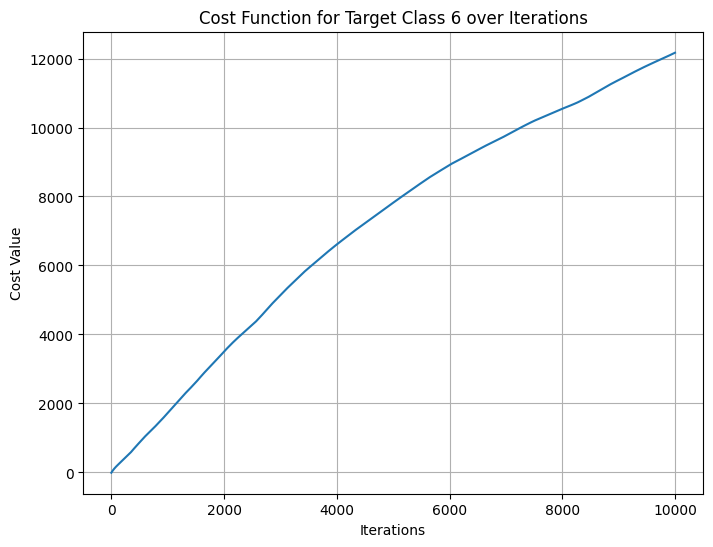

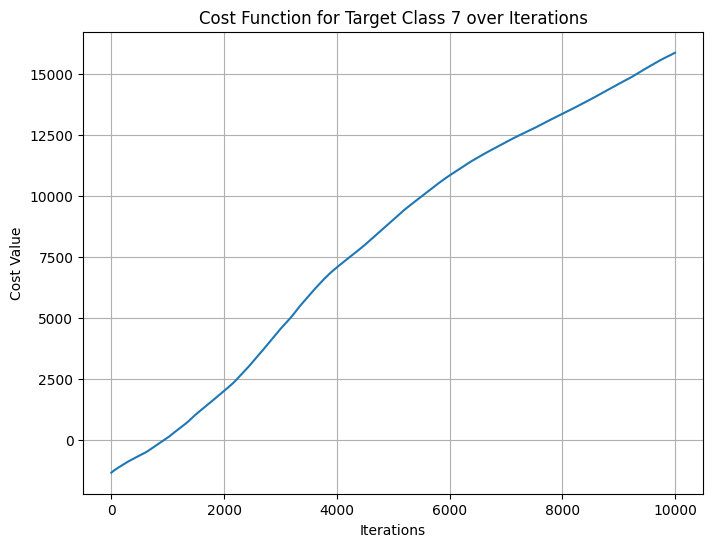

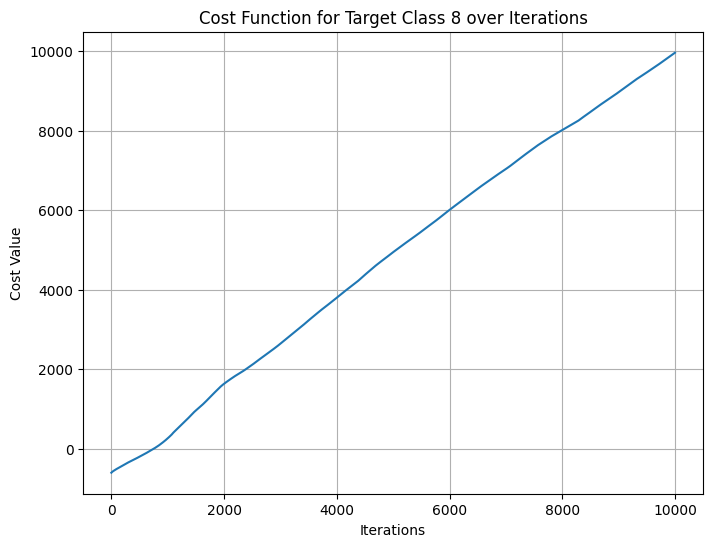

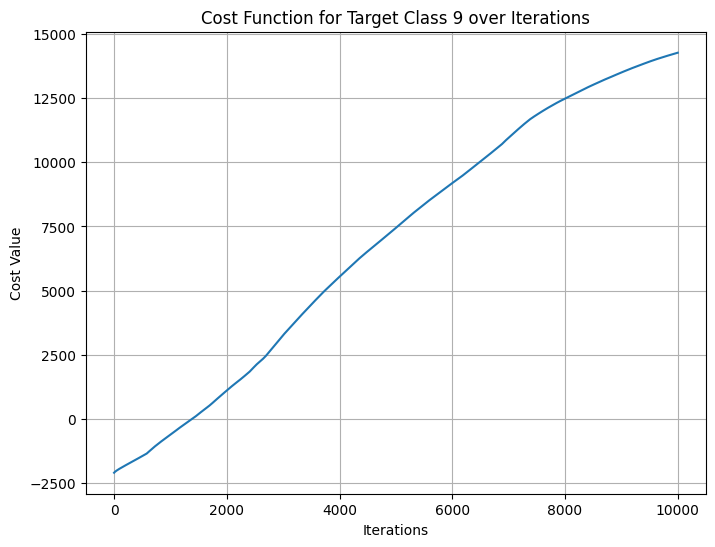

In [48]:
for i in range(10):
  plot_costs_for_target_class(generated_examples, i)

# Targeted Attack

In [49]:
def generate_target_adversarial_example(model, target_class, target_image, stepsize=0.05, max_iterations=5000, epsilon=0.3, use_epsilon=True, beta=0.001):
  model.eval() # model to evaluation

  X = torch.normal(128, 1, (1, 1, 28, 28)).to(device) # normal distribution centered at 128
  X.requires_grad = True # gradient computation for X
  mse_loss = nn.MSELoss() # Mean Squared Error (MSE) loss

  for iteration in range(max_iterations):
    logits = model(X)
    cost = logits[0, target_class] - beta * mse_loss(X, target_image) # aversarial cost function for the target class

    model.zero_grad()
    cost.backward() # Backpropagate to compute the gradients

    perturbation = stepsize * X.grad.data # Compute the perturbation to add to X
    if use_epsilon:
      perturbation = torch.clamp(perturbation, -epsilon, epsilon) # perturbation to be within the range [-epsilon, epsilon]
    X.data = X.data + perturbation

    X.data = torch.clamp(X.data, 0, 255)
    X.grad.data.zero_()

  return X.detach()

In [50]:
def classwise_adversarial_example(model, dataset, beta=0.001):
  target_images = {} # dictionary to store target images

  # Iterate through the dataset to collect one image for each class (0-9)
  for _, (images, labels) in enumerate(dataset):
    for img, label in zip(images, labels):
      if label.item() not in target_images:
        target_images[label.item()] = img.to(device)
      if len(target_images) == 10: # Stop if we collected images for all 10 classes
        break
    if len(target_images) == 10:
      break

  adversarial_images = {} # dictionary to store the adversarial images
  for true_digit, target_img in target_images.items(): # Create adversarial images for each target digit from 0 to 9
    for target_digit in range(10):
      if true_digit != target_digit:
        adv_img = generate_target_adversarial_example(model, target_digit, target_img.unsqueeze(0), beta=beta)
        adversarial_images[(true_digit, target_digit)] = adv_img

  # Displaying the generated images
  plt.figure(figsize=(20, 20))
  for i, ((true_digit, target_digit), img) in enumerate(adversarial_images.items()):
    plt.subplot(10, 9, i+1)
    plt.imshow(img[0,0].cpu().numpy(), cmap='gray')
    plt.title(f"Looks: {true_digit}, Predicted: {target_digit}", fontsize=10)
    plt.axis('off')
  plt.tight_layout()
  plt.show()

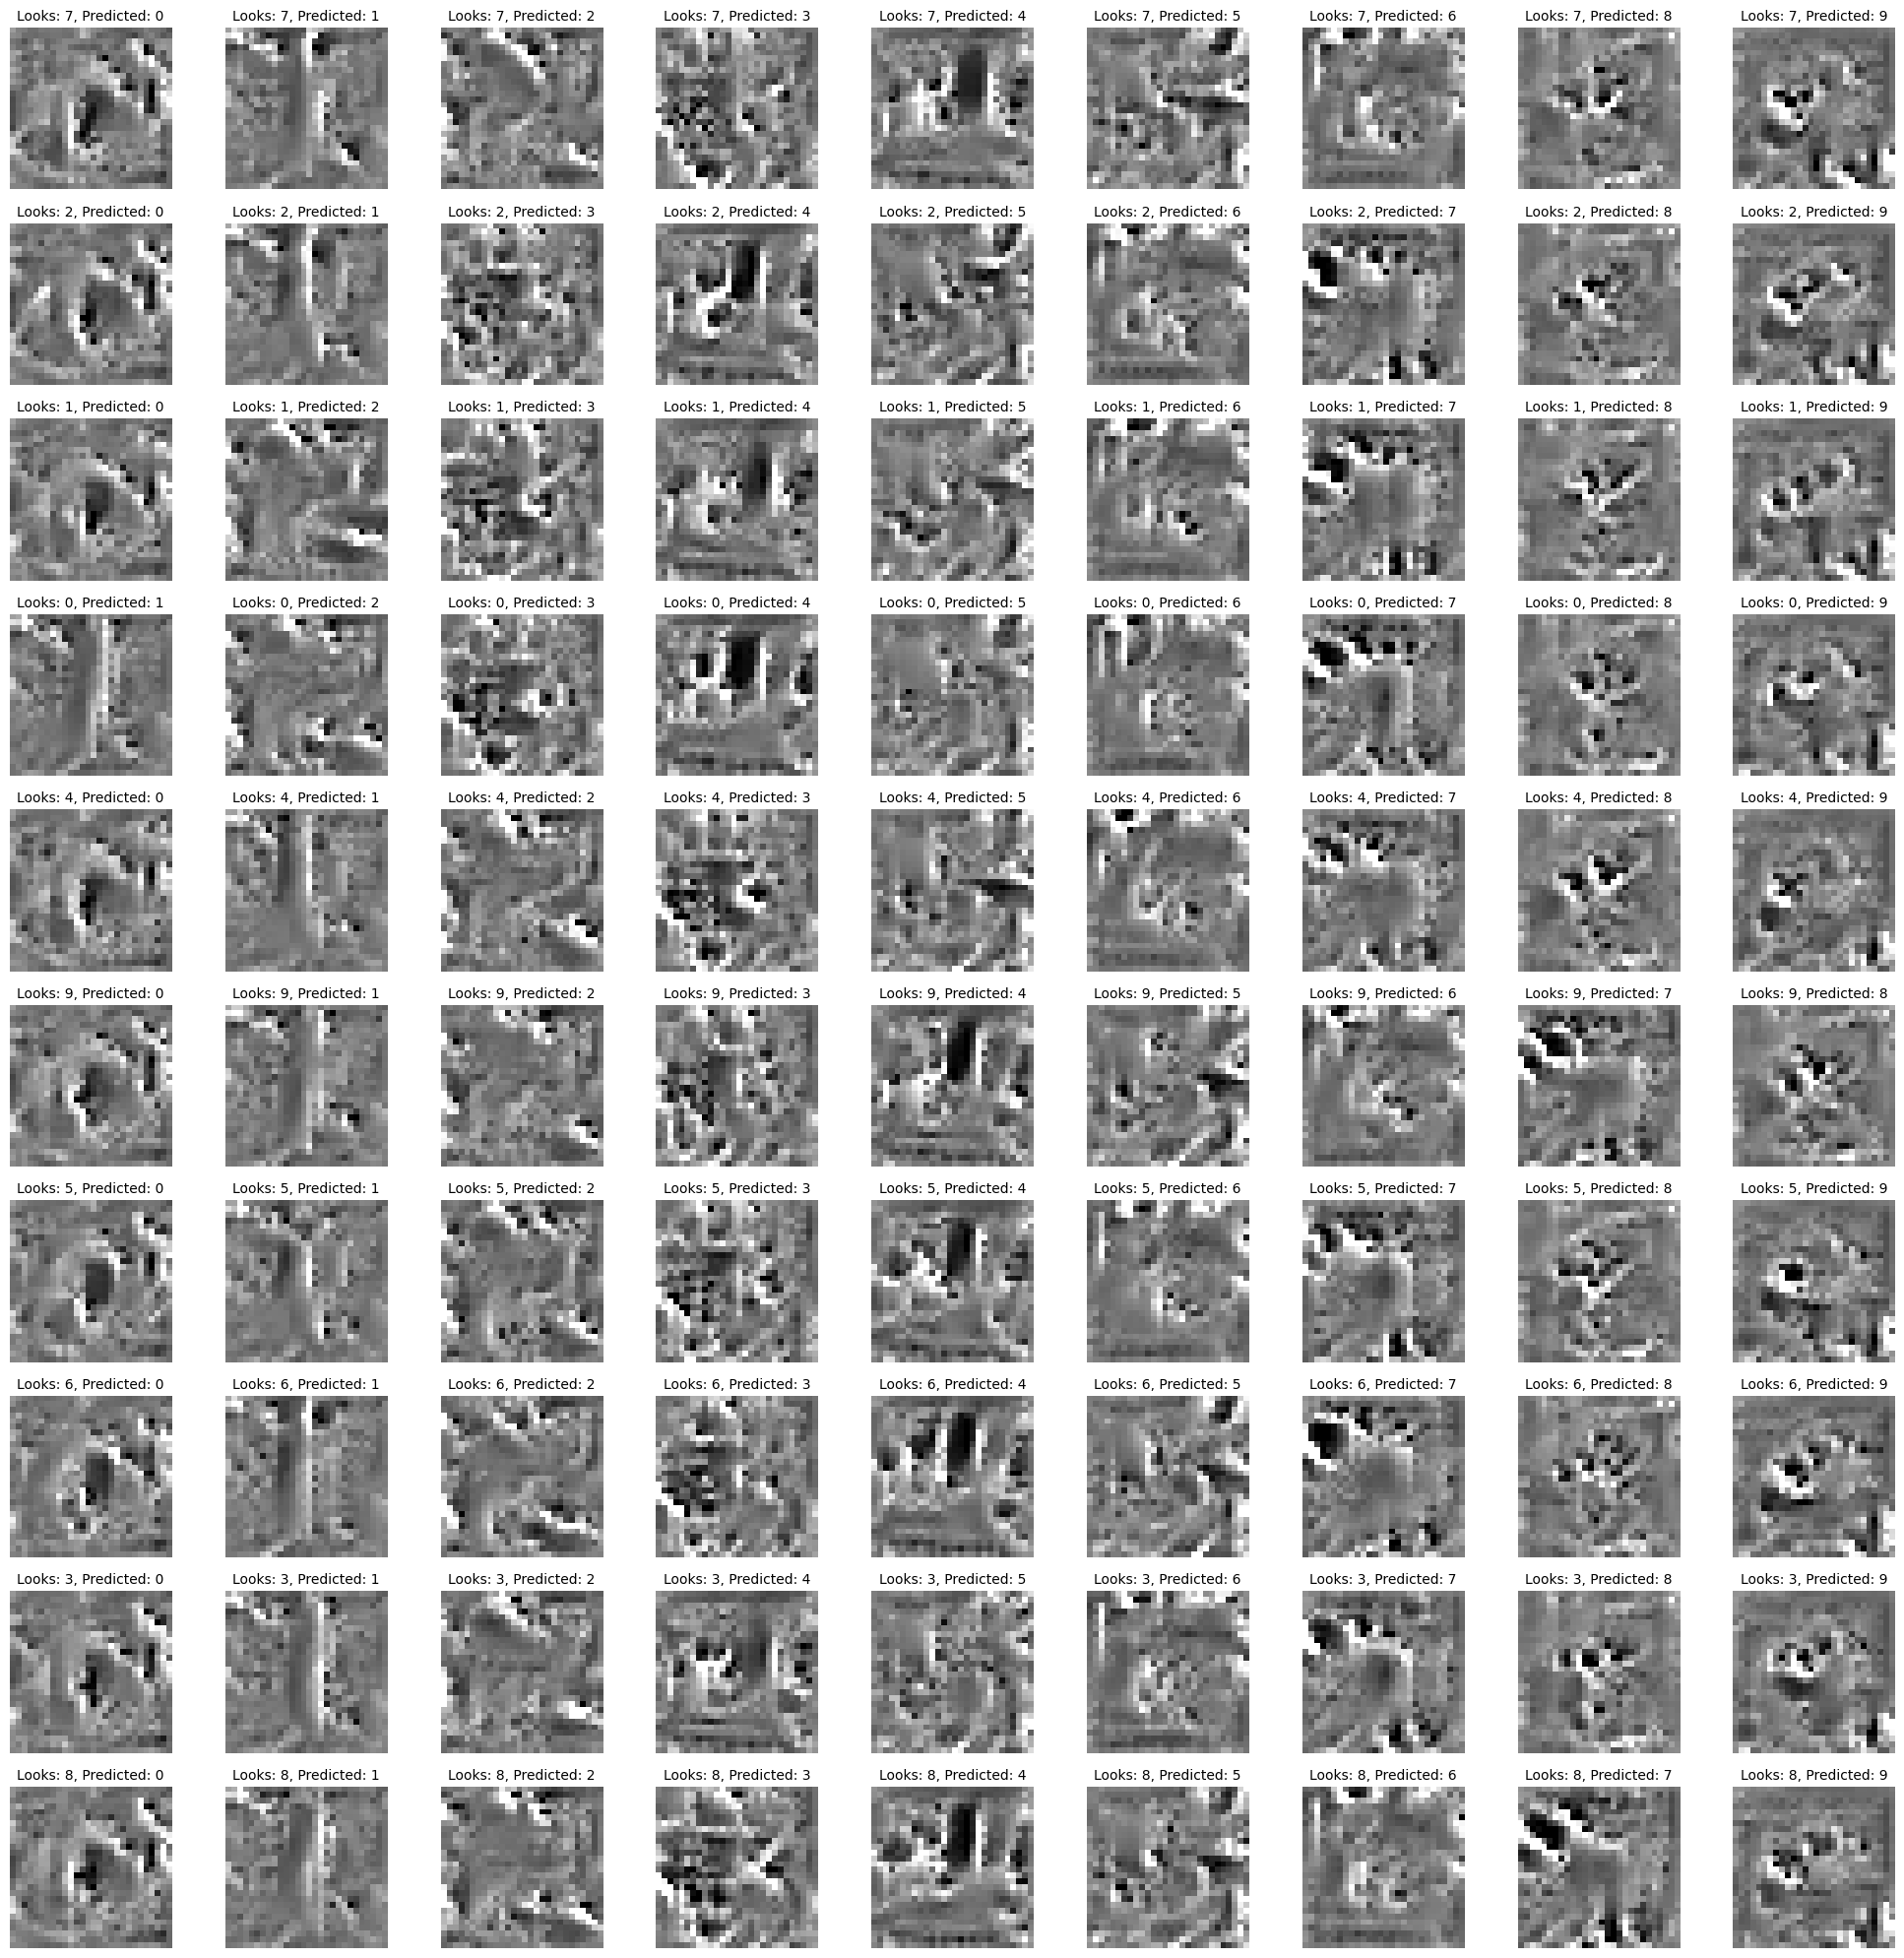

In [51]:
classwise_adversarial_example(adam_batch_model, test_loader)
